In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset

from torchvision import transforms
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import time
import copy

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fcn')

In [2]:
class PhysionetDataset(Dataset):
    def __init__(self, dataset_path, train=True, debug=False, label_encoding=True, split=True):
        """
        Args:
            dataset_dir (string): Path to Physionet MMI dataset (imagine only) with .pickle extensions
        """
        self.label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}

        self.X = pickle.load(open(dataset_path, 'rb'))
        self.y = self.X['train_y']
        self.X = self.X['train_x']

        if label_encoding:
            self.y = np.vectorize(self.label_map.__getitem__)(self.y)

        if debug:
            self.y = self.y[:1000]
            self.X = self.X[:1000]

        if split:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, shuffle=True, random_state=random_seed, stratify=self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()

        sample = self.X[idx], self.y[idx]
        return sample

    def get_labels(self):
        return np.unique(self.y)

In [3]:
X = pickle.load(open('../dataset/train/cross_subject_data_5_subjects.pickle', 'rb'))
y = X['train_y']

X = X['train_x'].astype(np.float32)

label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}
y = np.vectorize(label_map.__getitem__)(y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
def print_class_dist(y):
    dist = {}

    labels = np.unique(y)
    for label in labels:
        dist[str(label)] = len(y[y == label]) / len(y)
    print(dist)
print_class_dist(y)
print_class_dist(y_train)
print_class_dist(y_test)

{'0': 0.2467187330513071, '1': 0.2532812669486929, '2': 0.2577286039700618, '3': 0.24227139602993816}
{'0': 0.246718303771938, '1': 0.253281696228062, '2': 0.2577264984788522, '3': 0.24227350152114777}
{'0': 0.24672045015423205, '1': 0.25327954984576795, '2': 0.25773702586353003, '3': 0.24226297413646994}


In [5]:
# Normalize
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [6]:
batch_size = 64

X_train, y_train = torch.tensor(X_train).to(device), torch.tensor(y_train).to(device)
X_test, y_test = torch.tensor(X_test).to(device), torch.tensor(y_test).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
dataloaders = {'train': train_loader, 'val': test_loader}
class_names = list(label_map.keys())
print(class_names)

['imagine_both_feet', 'imagine_both_fist', 'imagine_left_fist', 'imagine_right_fist']


In [7]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [8]:
input_size = 64
hidden_size_1 = 512
hidden_size_2 = 512
num_classes = 4
num_epochs = 10
batch_size = 100

class FCN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(FCN, self).__init__()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.l1 = nn.Linear(input_size, hidden_size_1)
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.l3 = nn.Linear(hidden_size_2, num_classes)
    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu1(out)
        out = self.l3(out)
        return out

model = FCN(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

writer.add_graph(model, X_train[0])

model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.1334 Acc: 0.4573
val Loss: 0.9631 Acc: 0.5585

Epoch 1/19
----------
train Loss: 0.8542 Acc: 0.6149
val Loss: 0.7471 Acc: 0.6660

Epoch 2/19
----------
train Loss: 0.7065 Acc: 0.6873
val Loss: 0.6977 Acc: 0.6898

Epoch 3/19
----------
train Loss: 0.6336 Acc: 0.7209
val Loss: 0.6320 Acc: 0.7205

Epoch 4/19
----------
train Loss: 0.5868 Acc: 0.7443
val Loss: 0.6078 Acc: 0.7310

Epoch 5/19
----------
train Loss: 0.5488 Acc: 0.7629
val Loss: 0.5926 Acc: 0.7391

Epoch 6/19
----------
train Loss: 0.5213 Acc: 0.7772
val Loss: 0.5654 Acc: 0.7512

Epoch 7/19
----------
train Loss: 0.4952 Acc: 0.7897
val Loss: 0.5676 Acc: 0.7537

Epoch 8/19
----------
train Loss: 0.4736 Acc: 0.8007
val Loss: 0.5535 Acc: 0.7621

Epoch 9/19
----------
train Loss: 0.4513 Acc: 0.8107
val Loss: 0.5758 Acc: 0.7633

Epoch 10/19
----------
train Loss: 0.4370 Acc: 0.8188
val Loss: 0.5476 Acc: 0.7686

Epoch 11/19
----------
train Loss: 0.4176 Acc: 0.8281
val Loss: 0.5436 Acc: 0.7737

Ep

In [11]:
_, y_pred = torch.max(model(X_test), 1)

tensor([1, 0, 0,  ..., 3, 3, 0], device='cuda:0')

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cr)

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cm)

y_pred_ohe = np.zeros((y_pred.size(0), num_classes))
for i, j in enumerate(y_pred):
    y_pred_ohe[i, j] = 1

y_test_ohe = np.zeros((y_test.size(0), num_classes))
for i, j in enumerate(y_test):
    y_test_ohe[i, j] = 1
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovo')
writer.add_scalar('AUROC OvO', auroc)
print('AUROC ovo:', auroc)
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovr')
writer.add_scalar('AUROC OvR', auroc)
print('AUROC ovr:', auroc)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     14557
           1       0.77      0.81      0.79     14944
           2       0.81      0.78      0.80     15207
           3       0.80      0.77      0.79     14294

    accuracy                           0.79     59002
   macro avg       0.79      0.79      0.79     59002
weighted avg       0.79      0.79      0.79     59002

[[11456  1488   842   771]
 [ 1304 12099   778   763]
 [ 1049  1095 11924  1139]
 [  998  1130  1165 11001]]
AUROC ovo: 0.858410325586389
AUROC ovr: 0.858410325586389


In [45]:
{str(v): k for k, v in label_map.items()}

{'0': 'imagine_both_feet',
 '1': 'imagine_both_fist',
 '2': 'imagine_left_fist',
 '3': 'imagine_right_fist'}

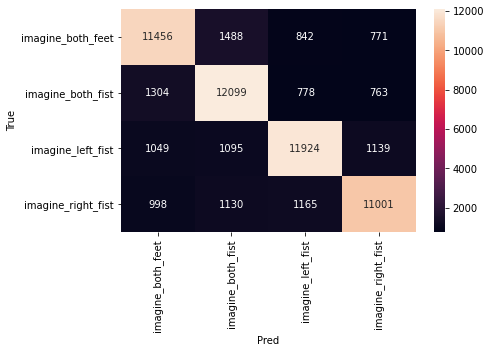

In [66]:
import seaborn as sns
import pandas as pd
import io

figure = plt.figure(figsize=(7, 5))
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
sns.heatmap(cm_df, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig('runs/fcn/cm.png')
plt.show()

In [2]:
for param in model.parameters():
    print(len(param))

NameError: name 'model' is not defined